การเรียนรู้แบบถ่ายโอน (Transfer Learning)

คือเทคนิคที่ช่วยให้เราสามารถนำรูปแบบหรือ "น้ำหนัก" ที่โมเดลอื่นได้เรียนรู้จากปัญหาอื่นมาใช้กับปัญหาของเราเองได้

ตัวอย่างเช่น เราสามารถนำรูปแบบที่โมเดลการมองเห็นคอมพิวเตอร์ (Computer Vision Model) ได้เรียนรู้จากชุดข้อมูล ImageNet (ซึ่งมีภาพล้านๆ ภาพของวัตถุที่แตกต่างกัน) มาใช้เพื่อสร้างโมเดล **FoodVision Mini** ของเราได้

หรือเราสามารถนำรูปแบบจากโมเดลที่ใช้สำหรับการประมวลผลภาษาธรรมชาติ (Language Model) ซึ่งเรียนรู้จากข้อความจำนวนมาก มาเป็นพื้นฐานในการสร้างโมเดลที่ใช้ในการจำแนกข้อความที่แตกต่างกัน

หลักการสำคัญของการเรียนรู้แบบถ่ายโอนคือการค้นหาโมเดลที่ทำงานได้ดีในปัญหาอื่น แล้วนำมาประยุกต์ใช้กับปัญหาของเราเอง.

# 06. Pytorch Transfer Learning
What is transfer learning?

transfer leaening involves taking parmeters of what one model has learned on another dataset and applying to own problem.

  * Pretraningmodel = foundation models

**Transfer Learning** คือกระบวนการที่นำพารามิเตอร์ (เช่น น้ำหนักหรือรูปแบบที่โมเดลได้เรียนรู้)

 จากโมเดลที่ได้รับการฝึกบนชุดข้อมูลหนึ่งไปใช้กับปัญหาของเราเอง ซึ่งช่วยลดเวลาการฝึกโมเดลใหม่ตั้งแต่ต้นได้

**Pretrained Models** หรือที่เรียกว่า **Foundation Models** คือโมเดลที่ผ่านการฝึกอบรมล่วงหน้าแล้วบนชุดข้อมูลขนาดใหญ่ และเราสามารถใช้โมเดลเหล่านี้เป็นฐานในการฝึกเพิ่มเติมเพื่อแก้ปัญหาเฉพาะทางของเรา

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.4.1+cu121
torchvision version: 0.19.1+cu121


import modular

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Thu Oct 10 07:48:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#1. Get data
We need our pizza, steak, sushi data to build a transfer learning model on

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food101 dataset

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download.")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists, skipping re-download.


In [ ]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))


# 2. Create Datasets and DataLoaders
Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in 05. PyTorch Going Modular.

There's one thing we have to think about when loading: how to **transform** it?

And with `torchvision` 0.13+ there's two ways to do this:

1. Manually created transforms - you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

Important point: when using a pretrained model, it's important that the data (including your custom data) that you pass through it is **transformed** in the same way that the data the model was trained on.
>สร้างชุดข้อมูลและ DataLoaders
>
>ตอนนี้เราได้ข้อมูลมาแล้ว เราต้องการแปลงมันให้เป็น PyTorch DataLoaders
>
>เพื่อทำเช่นนี้ เราสามารถใช้ไฟล์ `data_setup.py` และฟังก์ชัน `create_dataloaders>()` ที่เราได้สร้างไว้ในบทที่ 05 (PyTorch Going Modular)
>
>อย่างไรก็ตาม มีสิ่งหนึ่งที่เราต้องพิจารณาเมื่อทำการโหลดข้อมูล: จะ **แปลง (transform)** ข้อมูลอย่างไร?
>
>ด้วย `torchvision` เวอร์ชัน 0.13+ มีสองวิธีในการทำสิ่งนี้:
>
>1. การสร้าง transforms แบบกำหนดเอง - คุณจะต้องกำหนดว่าคุณต้องการให้ข้อมูลของคุณผ่านการแปลงแบบใด
2. การสร้าง transforms แบบอัตโนมัติ - การแปลงข้อมูลของคุณจะถูกกำหนดโดยโมเดลที่คุณต้องการใช้
>
>จุดสำคัญ: เมื่อใช้โมเดลที่ผ่านการฝึกมาก่อน (pretrained model) สิ่งสำคัญคือข้อมูล (รวมถึงข้อมูลที่คุณปรับแต่งเอง) ที่คุณส่งผ่านโมเดลนั้นควรได้รับการ **แปลง (transform)** ในลักษณะเดียวกับข้อมูลที่โมเดลนั้นถูกฝึกมา
>
>

In [ ]:
from going_modular.going_modular import data_setup

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize.
>
>

2.1 การสร้าง transform สำหรับ `torchvision.models` (การสร้างแบบ manual)

`torchvision.models` ประกอบด้วยโมเดลที่ถูกฝึกมาแล้ว (pretrained models) ซึ่งพร้อมสำหรับการใช้งาน transfer learning ภายใน `torchvision`

> โมเดลที่ถูกฝึกมาทั้งหมดคาดหวังให้ภาพอินพุตได้รับการปรับค่าในลักษณะเดียวกัน นั่นคือ mini-batches ของภาพ RGB ที่มี 3 ช่องสัญญาณ ในรูปแบบ (3 x H x W) ซึ่ง H และ W ควรมีขนาดอย่างน้อย 224 ภาพจะต้องถูกโหลดให้มีค่าช่วงระหว่าง [0, 1] และจากนั้นปรับค่าให้เป็นปกติ (normalized) โดยใช้ค่า mean = [0.485, 0.456, 0.406] และ std = [0.229, 0.224, 0.225] คุณสามารถใช้ transform ต่อไปนี้เพื่อปรับค่าให้เป็นปกติ

In [ ]:
from torchvision import transforms
# Create a transform for image data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
manual_transform = transforms.Compose([
  transforms.Resize((224, 224)), # Resize to 224x224px
  transforms.ToTensor(), # Convert image to PyTorch Tensor
  normalize # Normalize pixel values
])

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78dae5f02110>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Createing a transform for `torchvision.models` (auto creation)
As of torchvision v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you're using.

In [ ]:
import torchvision
torchvision.__version__

'0.19.1+cu121'

In [ ]:
#Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # use default is best avaliable weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transform used to create our pretrained weights
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
#Create Dataloader useing autometic transform
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transform,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78da2fc2af20>,
 ['pizza', 'steak', 'sushi'])

### 3.1 Which pretrained model should you use?

*Experiment, experiment, experiment!*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed - how fast does it need to run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images? for FoodVision Mini)?

Where does the model live?

Is it on device? (like a self-driving car)

Or does it live on a server?

Looking at https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

Which model should we chose?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms performance vs size.

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could - http://www.incompleteideas.net/IncIdeas/BitterLesson.html

### 3.1 เราควรเลือกโมเดลที่ผ่านการฝึกมาแล้วแบบไหน?

*ทดลอง ทดลอง ทดลอง!*

แนวคิดของการเรียนรู้แบบถ่ายโอน (Transfer Learning) คือการนำโมเดลที่มีประสิทธิภาพดีในปัญหาที่คล้ายคลึงกับปัญหาของคุณ แล้วปรับแต่งให้เหมาะสมกับปัญหาของคุณเอง

มี 3 สิ่งที่ควรพิจารณา:
1. ความเร็ว - ต้องการให้ทำงานได้เร็วแค่ไหน?
2. ขนาด - ขนาดของโมเดลใหญ่แค่ไหน?
3. ประสิทธิภาพ - โมเดลทำงานได้ดีแค่ไหนในปัญหาที่เลือก (เช่น การจำแนกภาพอาหารได้ดีเพียงใดสำหรับ FoodVision Mini)?

โมเดลอยู่ที่ไหน?

อยู่บนอุปกรณ์หรือไม่? (เช่น รถยนต์ขับเคลื่อนอัตโนมัติ)

หรือโมเดลอยู่บนเซิร์ฟเวอร์?

ดูที่ https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

เราควรเลือกโมเดลไหน?

สำหรับกรณีของเรา (การปรับใช้ FoodVision Mini บนอุปกรณ์มือถือ) ดูเหมือนว่า EffNetB0 จะเป็นหนึ่งในตัวเลือกที่ดีที่สุดในแง่ของประสิทธิภาพเมื่อเทียบกับขนาด

อย่างไรก็ตาม ตามที่กล่าวในบทเรียน The Bitter Lesson ถ้าเรามีทรัพยากรคอมพิวเตอร์ไม่จำกัด เราอาจเลือกโมเดลที่ใหญ่ที่สุด + มีจำนวนพารามิเตอร์มากที่สุด + ที่มีความทั่วไปมากที่สุด - http://www.incompleteideas.net/IncIdeas/BitterLesson.html

##3.2 Setting up a pretrained model
Want to create an instance of a pretrained EffNetB0 - https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights

 การตั้งค่าโมเดลที่ผ่านการฝึกอบรมล่วงหน้าด้วย Torchvision

In [ ]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # ".DEFAULT" = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

##3.3 Getting a summary of our model with torchinfo.summary()
สรุปของเลเยอร์ต่างๆ ของโมเดล

In [ ]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

##3.4 Freezing the base model and changing the output layer to suit our needs
With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundation model and update the output layers to suit your own problem.

การแช่แข็งเลเยอร์ฐานของโมเดลของเราและการอัปเดตหัวจําแนกประเภท

In [ ]:
# Freeze all of the base layers in EffNetB0 แช่แข็งเพื่อไม่ให้ข้อมูลในโมเดลชุดเก่าไม่ถูกเปลี่ยนแปลงหรือเรียนรู้ใหม่ได้
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False

In [ ]:
len(class_names)

3

In [ ]:
from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True)).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

##4. Train model

In [ ]:
#define loss_fn & optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
# import train function
from going_modular.going_modular import engine
#set manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#start timer
from timeit import default_timer as timer
start_time = timer()
#setup train and save a results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=5,
                       device=device)
#end timer and print
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0796 | train_acc: 0.4336 | test_loss: 0.8917 | test_acc: 0.6420
Epoch: 2 | train_loss: 0.8470 | train_acc: 0.8477 | test_loss: 0.7980 | test_acc: 0.8447
Epoch: 3 | train_loss: 0.7521 | train_acc: 0.8281 | test_loss: 0.7580 | test_acc: 0.8447
Epoch: 4 | train_loss: 0.6951 | train_acc: 0.7812 | test_loss: 0.6564 | test_acc: 0.8561
Epoch: 5 | train_loss: 0.5988 | train_acc: 0.8203 | test_loss: 0.6502 | test_acc: 0.8144
[INFO] Total training time: 24.198 seconds


##5. Evalaute model by plotting loss curves

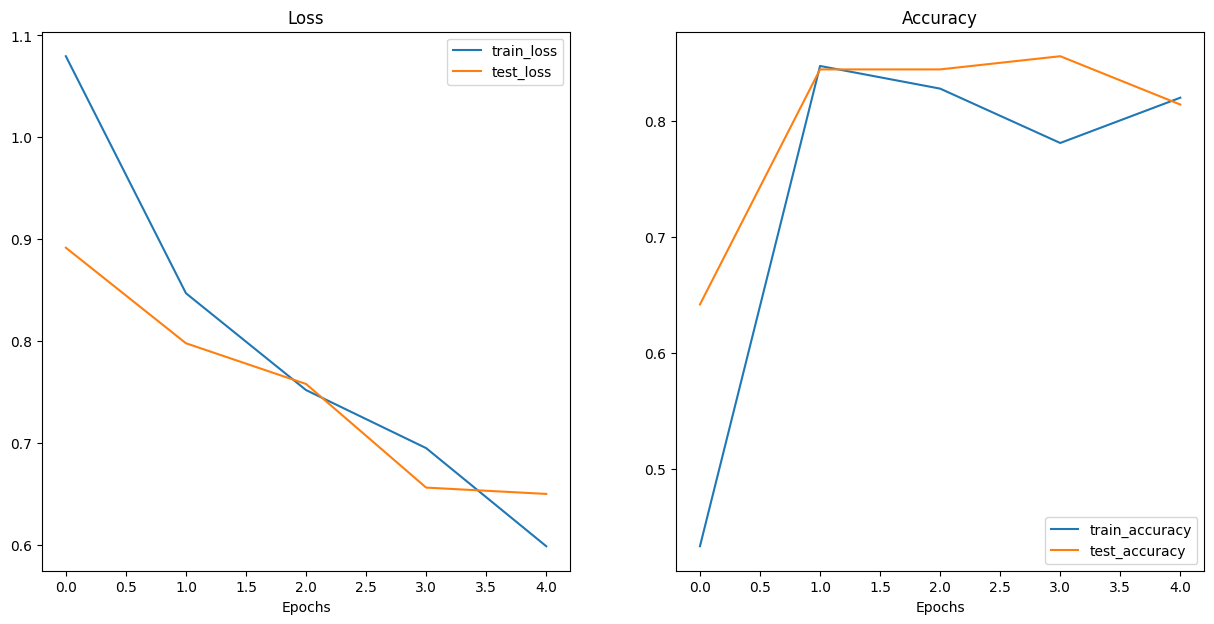

In [ ]:
try:
  from helper_functions import plot_loss_curves
except:
  print("helper_functions.py not found, downloading...")
  with open("helper_functions.py", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves
#plot the loss curver result
plot_loss_curves(results)


What do our loss curves look like in terms of the ideal loss curve?

See here for more: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

##6. Make prediction on img from test set


Let's adhere to the data explorer's motto of *visualize, visualize, visualize*!

And make some qualitiative predictions on our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data should be on the same device as the model
* Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

To do all of this automagically, let's create a function called `pred_and_plot_image()`:

The function will be similar to the one here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8

In [ ]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms
# 1. Take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                        class_names: List[str],
                        image_path: str,
                        image_size: Tuple[int, int] = (224, 224),
                        transform=None,
                        device: torch.device = device):
  #2. Open image with PIL
  img = Image.open(image_path)
  #3. Create a transfrom
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
      transforms.Resize(image_size),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229,0.224,0.225]),
    ])
  ##Predict on img
  ### 4. Make sure the model is on the target device
  model.to(device)
  ### 5. Turn on model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
    ### 6. Transform and add an extra dimension to image
    transformed_image = image_transform(img).unsqueeze(dim=0)
    ### 7. Make a prediction on image with model
    target_image_pred = model(transformed_image.to(device))
    ### 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  ### 9. Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
  ### 10. Plot the image using matplotlib
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)

In [ ]:
class_names

['pizza', 'steak', 'sushi']

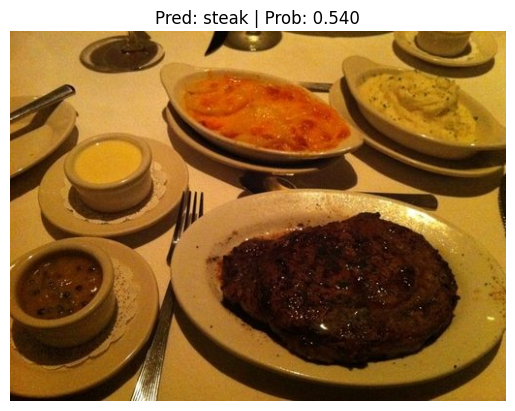

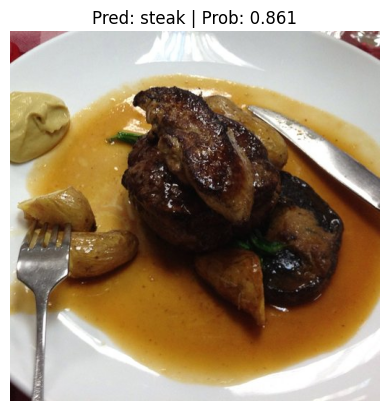

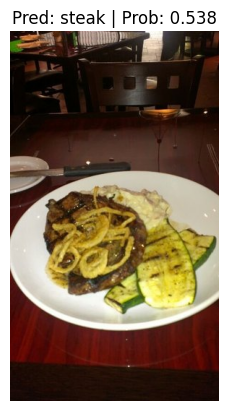

In [ ]:
#Get a random test
import random
num_img_to_plot = 3
test_img_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_img_path_sample = random.sample(population=test_img_path_list, k=num_img_to_plot)
test_img_path_sample
#make prediction on plot img
for img_path in test_img_path_sample:
  pred_and_plot_image(model=model,
                    class_names=class_names,
                    image_path=img_path,
                    image_size=(224, 224),
                    transform=auto_transform,
                    device=device)


##6.1 Making predictions on a custom image
Let's make a prediction on the pizza dad image - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg

In [ ]:
import requests
#setup custom img path
custom_img_path = data_path / "pizza_dad.jpeg"
#download custom img
if not custom_img_path.is_file():
  with open(custom_img_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true")
    print("Downloading custom image...")
    f.write(request.content)
else:
  print(f"{custom_img_path} already exists, skipping download...")
#


data/pizza_dad.jpeg already exists, skipping download...


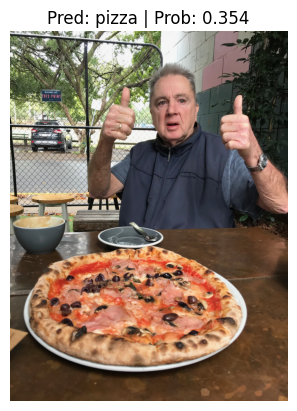

In [ ]:
#predict on custome img
pred_and_plot_image(model=model,
                    class_names=class_names,
                    image_path=custom_img_path,
                    image_size=(224, 224),
                    transform=auto_transform,
                    device=device)